In [1]:
import torch
import torch.nn as nn
from temporal_encoder import Temporal_Encoder
from spacial_encoder import Spacial_Encoder
from unet_decoder import Unet_Decoder
from data_loader import data_loader
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import pickle
from CNN import plot_losses
from temporal_spacial_encoder_decoder import *
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
!nvidia-smi -L

GPU 0: NVIDIA H100 80GB HBM3 (UUID: GPU-11362a1b-d337-c1eb-3eb4-958b52f5b4f2)


In [3]:
# Set paths
folder_path = "/home/hice1/ylu764/scratch"
feature_path = os.path.join(folder_path, "feature")  # Replace with your actual path
label_path = os.path.join(folder_path, "label")      # Replace with your actual path

# Load data
dl = data_loader(feature_path, label_path)
dl.check()
train_set, valid_set = torch.utils.data.random_split(dl, [int(len(dl)*0.8), len(dl) - int(len(dl)*0.8)])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False)

## Default config

In [4]:
temp_config = dict()
spacial_config = dict(in_channels=5, base_features=64, num_layers=4, use_skip=True)
decoder_config = dict(out_channels=1, base_features=64, num_layers=4)

## Load config from file

In [5]:
with open("/home/hice1/ylu764/scratch/TSED_0725/best_hyperparams.pkl", "rb") as fin:
    temp_config, spacial_config, decoder_config = pickle.load(fin)

In [6]:
print(temp_config)
print(spacial_config)
print(decoder_config)

{'embed_dim': 128, 'num_heads': 2, 'num_layers': 3, 'mlp_ratio': 1.5155049703739043}
{'base_features': 64, 'num_layers': 2}
{'out_channels': 1, 'num_layers': 2, 'bottleneck_channels': 256, 'use_skip': True}


In [7]:
temp_config = {'embed_dim': 64, 'num_heads': 2, 'num_layers': 3, 'mlp_ratio': 1.5155049703739043}
spacial_config = {'base_features': 64, 'num_layers': 2}
decoder_config = {'out_channels': 1, 'num_layers': 2, 'bottleneck_channels': 256, 'use_skip': True}

## Load the study

In [8]:
import optuna
output_dir = "/home/hice1/ylu764/scratch/TSED_0725"
prefix = "TSED_0725"
study = optuna.create_study(
    direction="minimize",
    study_name=prefix,
    storage=f"sqlite:///{output_dir}/study.db",
    load_if_exists=True
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-26 23:59:38,116] Using an existing study with name 'TSED_0725' instead of creating a new one.


In [9]:
print(study.best_trial)

FrozenTrial(number=13, state=TrialState.COMPLETE, values=[0.043310224723357424], datetime_start=datetime.datetime(2025, 7, 26, 6, 8, 13, 240593), datetime_complete=datetime.datetime(2025, 7, 26, 6, 28, 8, 424862), params={'base_features': 64, 'temporal_encoder.embed_dim': 128, 'temporal_encoder.num_heads': 2, 'temporal_encoder.num_layers': 3, 'temporal_encoder.mlp_ratio': 1.5155049703739043, 'spacial_encoder.num_layers': 2, 'learning_rate': 0.00025767686314748245}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'base_features': CategoricalDistribution(choices=(32, 64, 128, 256)), 'temporal_encoder.embed_dim': CategoricalDistribution(choices=(128, 256, 512, 1024, 2048)), 'temporal_encoder.num_heads': CategoricalDistribution(choices=(2, 4, 8, 16, 32, 64)), 'temporal_encoder.num_layers': IntDistribution(high=6, log=False, low=2, step=1), 'temporal_encoder.mlp_ratio': FloatDistribution(high=7.0, log=False, low=1.0, step=None), 'spacial_encoder.num_layers': IntDistri

## Train the model

In [8]:
model = FullModel(temp_config=temp_config, 
                  spacial_config=spacial_config,
                  decoder_config=decoder_config)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [9]:
prefix = "TSED_0726_ft_2"

100%|██████████| 65/65 [01:10<00:00,  1.08s/it]


[ Train | 001/100 ] loss = 0.20634


100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


[ Valid | 001/100 ] loss = 0.16084
[ Valid | 001/100 ] loss = 0.16084 -> best
Best model found at epoch 0, saving model


100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


[ Train | 002/100 ] loss = 0.086573


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 002/100 ] loss = 0.063004
[ Valid | 002/100 ] loss = 0.063004 -> best
Best model found at epoch 1, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 003/100 ] loss = 0.036603


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 003/100 ] loss = 0.030116
[ Valid | 003/100 ] loss = 0.030116 -> best
Best model found at epoch 2, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 004/100 ] loss = 0.025851


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 004/100 ] loss = 0.022971
[ Valid | 004/100 ] loss = 0.022971 -> best
Best model found at epoch 3, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 005/100 ] loss = 0.021204


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 005/100 ] loss = 0.019483
[ Valid | 005/100 ] loss = 0.019483 -> best
Best model found at epoch 4, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 006/100 ] loss = 0.018125


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 006/100 ] loss = 0.01699
[ Valid | 006/100 ] loss = 0.01699 -> best
Best model found at epoch 5, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 007/100 ] loss = 0.016264


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 007/100 ] loss = 0.015433
[ Valid | 007/100 ] loss = 0.015433 -> best
Best model found at epoch 6, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 008/100 ] loss = 0.014845


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 008/100 ] loss = 0.013994
[ Valid | 008/100 ] loss = 0.013994 -> best
Best model found at epoch 7, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 009/100 ] loss = 0.013811


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 009/100 ] loss = 0.013206
[ Valid | 009/100 ] loss = 0.013206 -> best
Best model found at epoch 8, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 010/100 ] loss = 0.012996


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 010/100 ] loss = 0.012424
[ Valid | 010/100 ] loss = 0.012424 -> best
Best model found at epoch 9, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 011/100 ] loss = 0.012307


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 011/100 ] loss = 0.0118
[ Valid | 011/100 ] loss = 0.0118 -> best
Best model found at epoch 10, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 012/100 ] loss = 0.011788


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 012/100 ] loss = 0.011663
[ Valid | 012/100 ] loss = 0.011663 -> best
Best model found at epoch 11, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 013/100 ] loss = 0.011323


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 013/100 ] loss = 0.010886
[ Valid | 013/100 ] loss = 0.010886 -> best
Best model found at epoch 12, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 014/100 ] loss = 0.01097


100%|██████████| 17/17 [00:13<00:00,  1.31it/s]


[ Valid | 014/100 ] loss = 0.01086
[ Valid | 014/100 ] loss = 0.01086 -> best
Best model found at epoch 13, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 015/100 ] loss = 0.01123


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 015/100 ] loss = 0.010791
[ Valid | 015/100 ] loss = 0.010791 -> best
Best model found at epoch 14, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 017/100 ] loss = 0.010358


100%|██████████| 17/17 [00:13<00:00,  1.31it/s]


[ Valid | 017/100 ] loss = 0.010056
[ Valid | 017/100 ] loss = 0.010056 -> best
Best model found at epoch 16, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 018/100 ] loss = 0.0099942


100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ Valid | 018/100 ] loss = 0.0096978
[ Valid | 018/100 ] loss = 0.0096978 -> best
Best model found at epoch 17, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 019/100 ] loss = 0.0098545


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 019/100 ] loss = 0.0094955
[ Valid | 019/100 ] loss = 0.0094955 -> best
Best model found at epoch 18, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 020/100 ] loss = 0.009668


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 020/100 ] loss = 0.009563
[ Valid | 020/100 ] loss = 0.009563


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 021/100 ] loss = 0.0095689


100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


[ Valid | 021/100 ] loss = 0.0091825
[ Valid | 021/100 ] loss = 0.0091825 -> best
Best model found at epoch 20, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 022/100 ] loss = 0.0095113


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 022/100 ] loss = 0.0098523
[ Valid | 022/100 ] loss = 0.0098523


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 023/100 ] loss = 0.0091342


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 023/100 ] loss = 0.0089471
[ Valid | 023/100 ] loss = 0.0089471 -> best
Best model found at epoch 22, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 024/100 ] loss = 0.0090438


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 024/100 ] loss = 0.0091807
[ Valid | 024/100 ] loss = 0.0091807


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 025/100 ] loss = 0.008909


100%|██████████| 17/17 [00:12<00:00,  1.31it/s]


[ Valid | 025/100 ] loss = 0.0087352
[ Valid | 025/100 ] loss = 0.0087352 -> best
Best model found at epoch 24, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 026/100 ] loss = 0.0089308


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 026/100 ] loss = 0.0095043
[ Valid | 026/100 ] loss = 0.0095043


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 027/100 ] loss = 0.0086902


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 027/100 ] loss = 0.0086361
[ Valid | 027/100 ] loss = 0.0086361 -> best
Best model found at epoch 26, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 028/100 ] loss = 0.0086553


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 028/100 ] loss = 0.0087167
[ Valid | 028/100 ] loss = 0.0087167


100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


[ Train | 029/100 ] loss = 0.0085928


100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


[ Valid | 029/100 ] loss = 0.0084487
[ Valid | 029/100 ] loss = 0.0084487 -> best
Best model found at epoch 28, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 030/100 ] loss = 0.0084169


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 030/100 ] loss = 0.0083603
[ Valid | 030/100 ] loss = 0.0083603 -> best
Best model found at epoch 29, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 031/100 ] loss = 0.0083976


100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ Valid | 031/100 ] loss = 0.0089314
[ Valid | 031/100 ] loss = 0.0089314


100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


[ Train | 032/100 ] loss = 0.008378


100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


[ Valid | 032/100 ] loss = 0.0084075
[ Valid | 032/100 ] loss = 0.0084075


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 033/100 ] loss = 0.0081696


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 033/100 ] loss = 0.0081116
[ Valid | 033/100 ] loss = 0.0081116 -> best
Best model found at epoch 32, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 034/100 ] loss = 0.0081589


100%|██████████| 17/17 [00:12<00:00,  1.31it/s]


[ Valid | 034/100 ] loss = 0.0080556
[ Valid | 034/100 ] loss = 0.0080556 -> best
Best model found at epoch 33, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 035/100 ] loss = 0.0082906


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 035/100 ] loss = 0.0081975
[ Valid | 035/100 ] loss = 0.0081975


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 036/100 ] loss = 0.0079942


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 036/100 ] loss = 0.0079258
[ Valid | 036/100 ] loss = 0.0079258 -> best
Best model found at epoch 35, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 037/100 ] loss = 0.0079088


100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ Valid | 037/100 ] loss = 0.0079074
[ Valid | 037/100 ] loss = 0.0079074 -> best
Best model found at epoch 36, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 038/100 ] loss = 0.0078491


100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ Valid | 038/100 ] loss = 0.0078202
[ Valid | 038/100 ] loss = 0.0078202 -> best
Best model found at epoch 37, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 039/100 ] loss = 0.0078477


100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ Valid | 039/100 ] loss = 0.0086655
[ Valid | 039/100 ] loss = 0.0086655


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 040/100 ] loss = 0.007714


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 040/100 ] loss = 0.0076981
[ Valid | 040/100 ] loss = 0.0076981 -> best
Best model found at epoch 39, saving model


100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


[ Train | 041/100 ] loss = 0.0076144


100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ Valid | 041/100 ] loss = 0.0078644
[ Valid | 041/100 ] loss = 0.0078644


100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


[ Train | 042/100 ] loss = 0.0075688


100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


[ Valid | 042/100 ] loss = 0.007607
[ Valid | 042/100 ] loss = 0.007607 -> best
Best model found at epoch 41, saving model


100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


[ Train | 043/100 ] loss = 0.0076446


100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


[ Valid | 043/100 ] loss = 0.0075561
[ Valid | 043/100 ] loss = 0.0075561 -> best
Best model found at epoch 42, saving model


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 044/100 ] loss = 0.0075811


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 044/100 ] loss = 0.007665
[ Valid | 044/100 ] loss = 0.007665


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 045/100 ] loss = 0.0075486


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 045/100 ] loss = 0.0074808
[ Valid | 045/100 ] loss = 0.0074808 -> best
Best model found at epoch 44, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 046/100 ] loss = 0.0075479


100%|██████████| 17/17 [00:13<00:00,  1.31it/s]


[ Valid | 046/100 ] loss = 0.0099139
[ Valid | 046/100 ] loss = 0.0099139


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 047/100 ] loss = 0.007377


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 047/100 ] loss = 0.0072977
[ Valid | 047/100 ] loss = 0.0072977 -> best
Best model found at epoch 46, saving model


100%|██████████| 65/65 [01:14<00:00,  1.15s/it]


[ Train | 048/100 ] loss = 0.0072466


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


[ Valid | 048/100 ] loss = 0.0074884
[ Valid | 048/100 ] loss = 0.0074884


100%|██████████| 65/65 [01:22<00:00,  1.27s/it]


[ Train | 049/100 ] loss = 0.0073429


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 049/100 ] loss = 0.009927
[ Valid | 049/100 ] loss = 0.009927


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 050/100 ] loss = 0.0073702


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 050/100 ] loss = 0.0073888
[ Valid | 050/100 ] loss = 0.0073888


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 051/100 ] loss = 0.0071963


 12%|█▏        | 2/17 [00:01<00:12,  1.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


[ Train | 085/100 ] loss = 0.0065102


100%|██████████| 17/17 [00:12<00:00,  1.31it/s]


[ Valid | 085/100 ] loss = 0.0066868
[ Valid | 085/100 ] loss = 0.0066868
Epoch 00085: reducing learning rate of group 0 to 6.2500e-07.


100%|██████████| 65/65 [01:07<00:00,  1.05s/it]


[ Train | 086/100 ] loss = 0.0065253


100%|██████████| 17/17 [00:12<00:00,  1.31it/s]


[ Valid | 086/100 ] loss = 0.0067466
[ Valid | 086/100 ] loss = 0.0067466


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 087/100 ] loss = 0.0064935


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 087/100 ] loss = 0.0066276
[ Valid | 087/100 ] loss = 0.0066276


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 088/100 ] loss = 0.0064937


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 088/100 ] loss = 0.0066661
[ Valid | 088/100 ] loss = 0.0066661


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 089/100 ] loss = 0.0065378


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 089/100 ] loss = 0.0066556
[ Valid | 089/100 ] loss = 0.0066556
Epoch 00089: reducing learning rate of group 0 to 3.1250e-07.


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 090/100 ] loss = 0.0064461


100%|██████████| 17/17 [00:13<00:00,  1.22it/s]


[ Valid | 090/100 ] loss = 0.0066001
[ Valid | 090/100 ] loss = 0.0066001 -> best
Best model found at epoch 89, saving model


100%|██████████| 65/65 [01:14<00:00,  1.14s/it]


[ Train | 091/100 ] loss = 0.0064951


100%|██████████| 17/17 [00:14<00:00,  1.19it/s]


[ Valid | 091/100 ] loss = 0.0066304
[ Valid | 091/100 ] loss = 0.0066304


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 092/100 ] loss = 0.0064536


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 092/100 ] loss = 0.0066189
[ Valid | 092/100 ] loss = 0.0066189


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 093/100 ] loss = 0.0065406


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 093/100 ] loss = 0.006633
[ Valid | 093/100 ] loss = 0.006633


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 094/100 ] loss = 0.0064848


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 094/100 ] loss = 0.0069701
[ Valid | 094/100 ] loss = 0.0069701
Epoch 00094: reducing learning rate of group 0 to 1.5625e-07.


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 095/100 ] loss = 0.006481


100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


[ Valid | 095/100 ] loss = 0.0065734
[ Valid | 095/100 ] loss = 0.0065734 -> best
Best model found at epoch 94, saving model


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 096/100 ] loss = 0.0064945


100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ Valid | 096/100 ] loss = 0.0066502
[ Valid | 096/100 ] loss = 0.0066502


100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


[ Train | 097/100 ] loss = 0.0064393


100%|██████████| 17/17 [00:13<00:00,  1.28it/s]


[ Valid | 097/100 ] loss = 0.0066165
[ Valid | 097/100 ] loss = 0.0066165


100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


[ Train | 098/100 ] loss = 0.0064256


100%|██████████| 17/17 [00:12<00:00,  1.31it/s]


[ Valid | 098/100 ] loss = 0.0065922
[ Valid | 098/100 ] loss = 0.0065922


100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


[ Train | 099/100 ] loss = 0.006492


100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ Valid | 099/100 ] loss = 0.0066064
[ Valid | 099/100 ] loss = 0.0066064
Epoch 00099: reducing learning rate of group 0 to 7.8125e-08.


100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


[ Train | 100/100 ] loss = 0.0065877


100%|██████████| 17/17 [00:13<00:00,  1.29it/s]


[ Valid | 100/100 ] loss = 0.0065891
[ Valid | 100/100 ] loss = 0.0065891


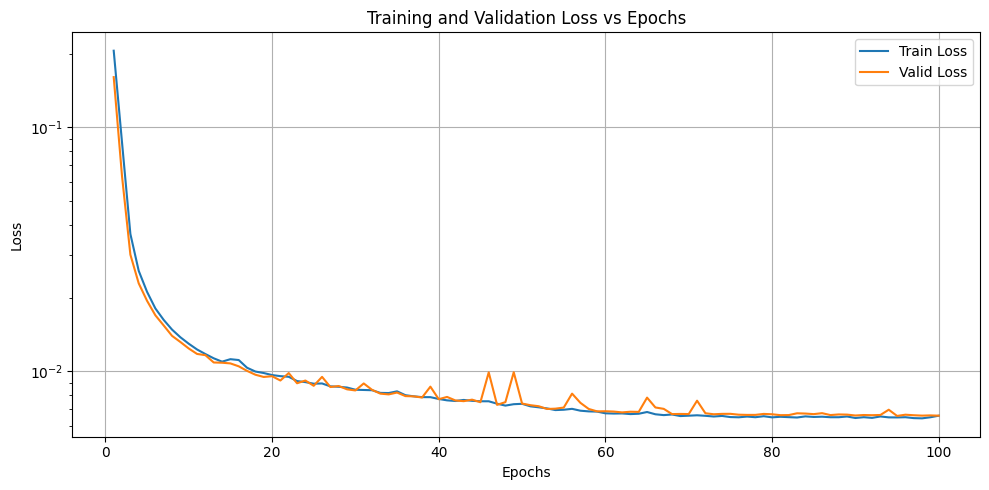

In [12]:
train_losses, valid_losses = train_temporal_spacial_model(model, 
                                                          optimizer, 
                                                          train_loader, 
                                                          valid_loader, 
                                                          n_epochs=100,
                                                          patience=30, 
                                                          criterion=criterion,
                                                          output_dir=f"scratch/{prefix}",
                                                          prefix=f"{prefix}",
                                                          scheduler=scheduler)
plot_losses(train_losses, valid_losses)

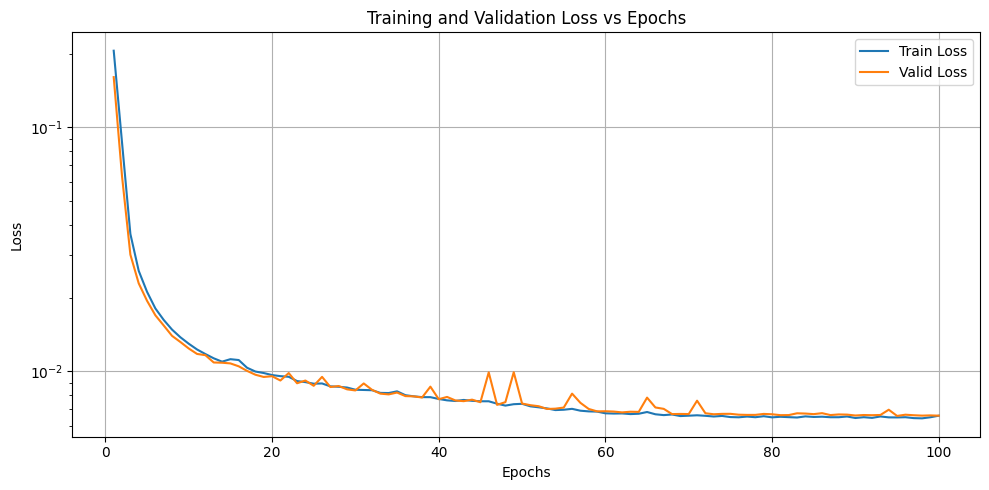

In [13]:
with open(f"./scratch/{prefix}/{prefix}_loss.pkl", "rb") as fin:
    loss_data = pickle.load(fin)

train_losses = loss_data["train"]
valid_losses = loss_data["validation"]
plot_losses(train_losses, valid_losses)

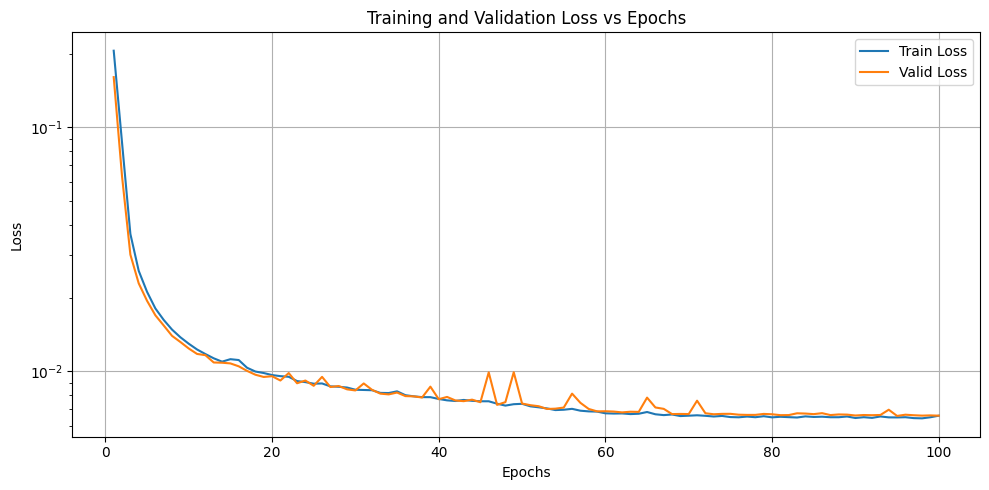

In [14]:
plot_losses(train_losses, valid_losses, img_path=f"scratch/{prefix}/loss.png")

In [15]:
# Print final statistics
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")
print(f"Best Validation MSE Loss: {min(valid_losses):.5f}")

Total Trainable Parameters: 10,408,801
Best Validation MSE Loss: 0.00657


In [10]:
# Load model
model = load_model_TESD("scratch/TSED_0726_ft_2/TSED_0726_ft_2_best.ckpt", temp_config, spacial_config, decoder_config)

In [12]:
evaluate_single_sample_TESD(model, valid_loader, output_path="scratch/TSED_0726_ft_2/comparison.png")

Comparison image saved to scratch/TSED_0726_ft_2/comparison.png
